# Step 4: Model Building

The data is ready for model training.

There are two primary steps in this process:
1) 
2) 

Thoughts: 
- I need to find the list price just before purchase for all recently sold properties. This list price should be used for calculating the price/sqft and should also be the target variable for training. Once the model has been trained, the predicted price should be compared to the sold price. Though, its likely the listed price just before sale is quite close to the sold price and thus, might not make a huge difference. 

Concerns: 
- I am concerned that the models are getting "future" data somehow... All these models perform better than 92% on training, testing, and live data...
- It is possible the price/sqft value is predicting the future. See "thoughts" above.

---

In [150]:
'''
Import libraries
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from itertools import cycle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from scipy.stats import ks_2samp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

pd.options.display.max_columns = None

In [151]:
'''
Build helper functions for code cleanliness
'''

# https://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Find best random state that minimizes the K-S distance:
# Use that min value for random state in the "actual" split below.
def minKS_tts(X, y, test_size):
    n_features = X.shape[1]
    n_tries = 100
    result = []
    for random_state in range(n_tries):
        X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=random_state)
        distances = list(map(lambda i : ks_2samp(X_train[:,i],X_test[:,i]).statistic,range(n_features)))
        result.append((random_state,max(distances)))
    result.sort(key = lambda x : x[1])
    return result[0][0]

# Matches 'series' column data statistical distribution to 'reference' column's statistical distribution.
# Uses ECDF
def match_ecdf(series, reference):
    sorted_series = np.sort(series, kind='mergesort')
    sorted_reference = np.sort(reference, kind='mergesort')
    ecdf_series = np.linspace(0, 1, len(series), endpoint=False)
    ecdf_reference = np.linspace(0, 1, len(reference), endpoint=False)
    matched_values = np.interp(ecdf_series, ecdf_reference, sorted_reference)
    matched_series = np.interp(sorted_series, sorted_series, matched_values)
    return matched_series


# Create function that determines optimal value of 'K' for KMeans clustering
def find_optimal_k(X, max_k=10):
    '''
    Find the optimal number of clusters (k) using the Elbow Method.

    ## Parameters:
    - X: Input data.
    - max_k: Maximum number of clusters to consider.

    ## Returns:
    - optimal_k: The optimal number of clusters.
    - inertia_values: List of inertia values for each k.
    '''

    # Initialize an empty list to store the sum of squared distances (inertia) for each k
    inertia_values = []

    # Define a range of k values (number of clusters)
    k_values = range(1, max_k + 1)

    # Iterate over each k value and fit the KMeans model
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    # Find the optimal k using the Elbow Method (simple heuristic: look for the "elbow" in the plot)
    optimal_k = np.argmin(np.diff(inertia_values)) + 1

    # Plot the Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.grid(True)
    plt.show()

    return optimal_k, inertia_values

In [152]:
'''
User Variables
'''

removeOutliers = False # If true, outliers will be removed.

In [153]:
'''
Read in csv files.
'''

df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold.drop(columns=['dateSold'], inplace=True)

df_forSale.rename(columns={'listPrice':'price'}, inplace=True)
df_recentlySold.rename(columns={'soldPrice':'price'}, inplace=True)

if removeOutliers:
    df_forSale = df_forSale.loc[df_forSale['Outlier']==0]
    df_recentlySold = df_recentlySold.loc[df_recentlySold['Outlier']==0]

# Build, Train, and Test K-Means Clustering Model.

In [154]:
'''
Drop unnecessary features.
'''

# Setting Target Variable for Regression Models
y_forSale = df_forSale['price']
y_recentlySold = df_recentlySold['price']

df_forSale.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)
df_recentlySold.drop(columns=['zpid','yearBuilt','price/sqft','zestimate','daysOnZillow'], inplace=True)

# Setting features for K-Means Clustering. Regression dataframes will be set further down.
X_forSale = df_forSale.copy()
X_recentlySold = df_recentlySold.copy()

df_forSale_cols = X_forSale.columns
df_recentlySold_cols = X_recentlySold.columns

In [155]:
'''
Scale Data for K-Means
'''

KM_feats = ['lotAreaValue','livingAreaValue','bathrooms','bedrooms','schoolMaxRating','schoolMinDistance','zipcode','resoFacts.taxAnnualAmount']

rs = StandardScaler()
KM_recentlySold = rs.fit_transform(X_recentlySold[KM_feats])
KM_forSale = rs.transform(X_forSale[KM_feats])

KM_recentlySold = pd.DataFrame(data=KM_recentlySold, columns=KM_feats)
KM_forSale = pd.DataFrame(data=KM_forSale, columns=KM_feats)

In [156]:
'''
Find best KMeans features and n_clusters
'''

kmeans_kwargs = {"init": "random","n_init": 20,"max_iter": 1000,"random_state": 1984}
maxvars=3
kmin=3
kmax=4

cols=list(KM_recentlySold.columns)

if len(cols) < (kmax-kmin+1)*maxvars:
    raise ValueError('Too few features. (kmax-kmin+1)*maxvars >= len(features)')

results_for_each_k=[]
vars_for_each_k={}

for k in range(kmin,kmax+1):
    selected_variables=[]
    while(len(selected_variables)<maxvars):
        results=[]
        for col in cols:
            scols=[]
            scols.extend(selected_variables)
            scols.append(col)
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(KM_recentlySold[scols])
            results.append(silhouette_score(KM_recentlySold[scols], kmeans.predict(KM_recentlySold[scols])))
        selected_var=cols[np.argmax(results)]
        selected_variables.append(selected_var)
        cols.remove(selected_var)
    results_for_each_k.append(max(results))
    vars_for_each_k[k]=selected_variables

best_k=np.argmax(results_for_each_k)+kmin
#you can also force a value for k
# best_k=3
selected_variables=vars_for_each_k[best_k]
kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
kmeans.fit(KM_recentlySold[selected_variables])
clusters=kmeans.predict(KM_recentlySold[selected_variables])

print(f'Best k: {best_k}')
print(f'Silhouette Score: {results_for_each_k[kmin-best_k]}')
print(f'Best Features: {selected_variables}')

Best k: 3
Silhouette Score: 0.5861933980993645
Best Features: ['bathrooms', 'lotAreaValue', 'livingAreaValue']


In [157]:
df_recentlySold.columns

Index(['zipcode', 'resoFacts.isSeniorCommunity', 'livingAreaValue',
       'resoFacts.taxAnnualAmount', 'bathrooms', 'bedrooms',
       'schoolMinDistance', 'resoFacts.hasWaterfrontView', 'longitude',
       'resoFacts.garageSpaces', 'latitude', 'lotAreaValue', 'schoolMaxRating',
       'cityId_124815', 'cityId_125641', 'cityId_13560', 'cityId_13752',
       'cityId_14563', 'cityId_19307', 'cityId_19341', 'cityId_20367',
       'cityId_25911', 'cityId_32805', 'cityId_39760', 'cityId_398464',
       'cityId_44434', 'cityId_46375', 'cityId_51467', 'cityId_52625',
       'cityId_53787', 'cityId_56330', 'cityId_7433', 'zipcode_32780',
       'zipcode_32796', 'zipcode_32901', 'zipcode_32903', 'zipcode_32904',
       'zipcode_32905', 'zipcode_32907', 'zipcode_32908', 'zipcode_32909',
       'zipcode_32920', 'zipcode_32922', 'zipcode_32926', 'zipcode_32927',
       'zipcode_32931', 'zipcode_32934', 'zipcode_32935', 'zipcode_32937',
       'zipcode_32940', 'zipcode_32949', 'zipcode_32950', 'zi

Silhouette score on recentlySold Data: 0.5861933980993645
Silhouette score on forSale Data: 0.5690127008592809


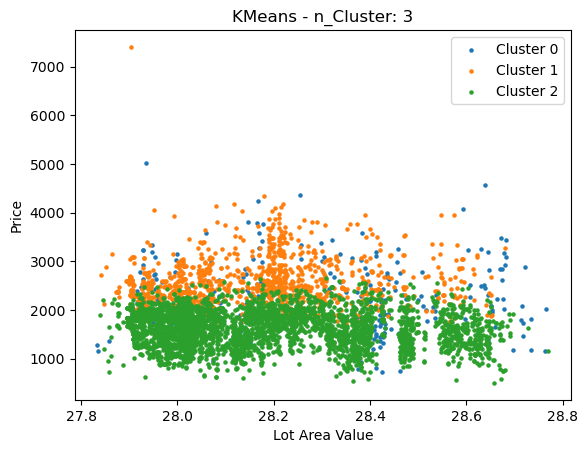

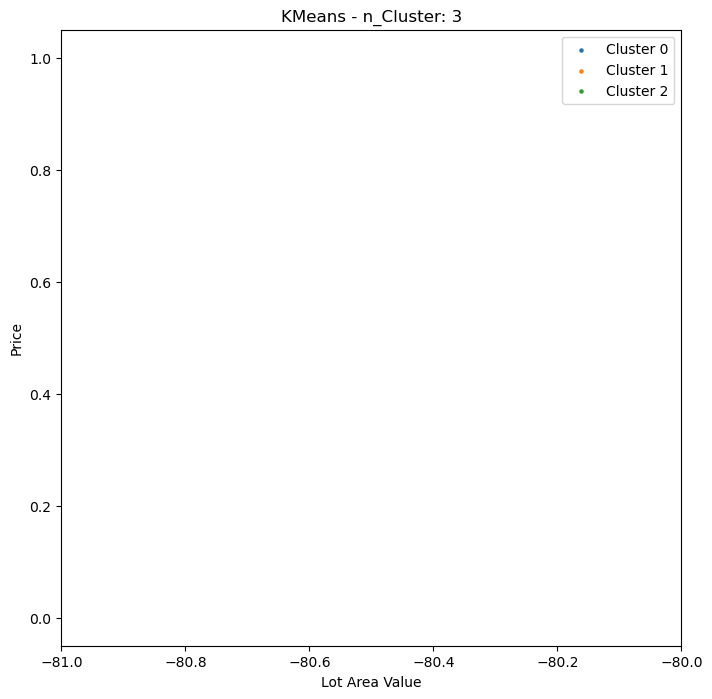

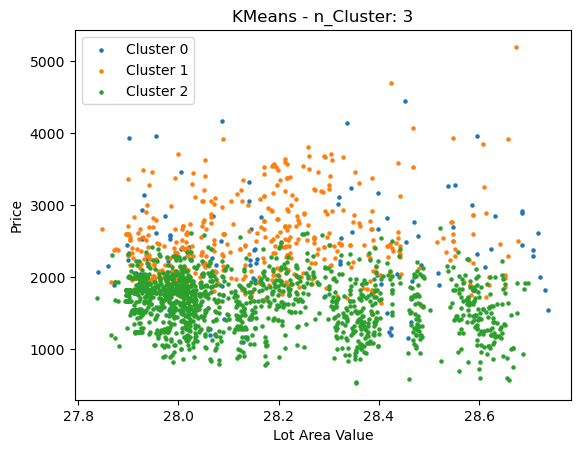

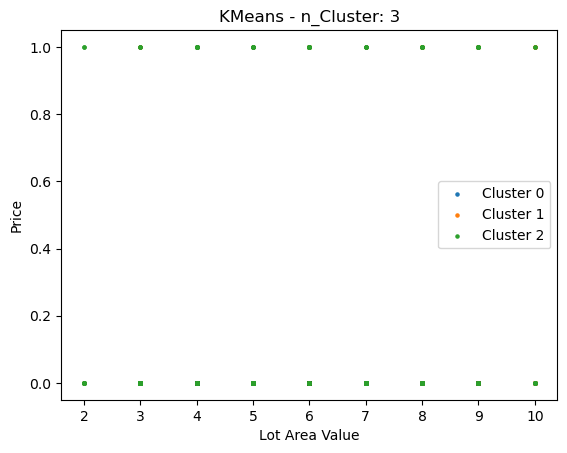

In [158]:
'''
KMeans to find best groups -- This clustering model needs to have some feature engineering done to it. Not currently looking that great!
'''

km = KMeans(n_clusters=best_k, **kmeans_kwargs)
km.fit(KM_recentlySold[selected_variables])
recentlySoldLabels = km.labels_
forSaleLabels = km.predict(KM_forSale[selected_variables])

score = silhouette_score(KM_recentlySold[selected_variables], recentlySoldLabels)
print(f'Silhouette score on recentlySold Data: {score}')
score = silhouette_score(KM_forSale[selected_variables], forSaleLabels)
print(f'Silhouette score on forSale Data: {score}')


# df_forSale.insert(25, 'KMeans', forSaleLabels, True)
# df_recentlySold.insert(25, 'KMeans', recentlySoldLabels, True)

'''
Plotting Below
'''

label2Print = [0,1,2]
keys = []
value = []
for i in range(best_k):
    keys.append(i)
    value.append(f'Cluster {i}')
labels=dict(zip(keys,value))

colors = cycle(cm.tab10.colors)
plt.figure()
# Plot recentlySold Clusters
for i in range(best_k):
    if i in label2Print:
        color = next(colors)
        idx = recentlySoldLabels==i
        plt.scatter(df_recentlySold.iloc[idx,10], df_recentlySold.iloc[idx,2], color=color, label=labels[i], s=5, alpha=1)
# plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
plt.xlabel('Lot Area Value')
plt.ylabel('Price')
plt.title(f'KMeans - n_Cluster: {best_k}')
plt.legend()
plt.show()

colors = cycle(cm.tab10.colors)
plt.figure(figsize=[8,8])
# Plot recentlySold Clusters
for i in range(best_k):
    if i in label2Print:
        color = next(colors)
        idx = recentlySoldLabels==i
        plt.scatter(df_recentlySold.iloc[idx,12], df_recentlySold.iloc[idx,15], color=color, label=labels[i], s=5, alpha=1)
# plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
plt.xlabel('Lot Area Value')
plt.ylabel('Price')
plt.xlim([-81, -80])
plt.title(f'KMeans - n_Cluster: {best_k}')
plt.legend()
plt.show()

colors = cycle(cm.tab10.colors)
plt.figure()
# Plot recentlySold Clusters
for i in range(best_k):
    if i in label2Print:
        color = next(colors)
        idx = forSaleLabels==i
        plt.scatter(df_forSale.iloc[idx,10], df_forSale.iloc[idx,2], color=color, label=labels[i], s=5, alpha=1)
# plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
plt.xlabel('Lot Area Value')
plt.ylabel('Price')
# plt.xlim([0, 300000])
plt.title(f'KMeans - n_Cluster: {best_k}')
plt.legend()
plt.show()

colors = cycle(cm.tab10.colors)
plt.figure()
# Plot recentlySold Clusters
for i in range(best_k):
    if i in label2Print:
        color = next(colors)
        idx = forSaleLabels==i
        plt.scatter(df_forSale.iloc[idx,12], df_forSale.iloc[idx,15], color=color, label=labels[i], s=5, alpha=1)
# plt.scatter(df_recentlySold.iloc[:,12], df_recentlySold.iloc[:,-1], c=recentlySoldLabels, s=3)
plt.xlabel('Lot Area Value')
plt.ylabel('Price')
plt.title(f'KMeans - n_Cluster: {best_k}')
plt.legend()
plt.show()

# Build, Train, Test, and Validate Regression Models on recentlySold Dataset

In [159]:
'''
Rebuiding dataframes for regression models
Drop multicollineated features
Drop price/sqft -- Since target is price, anything directly proportional to it needs to be removed.
https://www.kaggle.com/code/erick5/predicting-house-prices-with-machine-learning/notebook
'''

dropThese = ['zipcode','latitude']
df_forSale.drop(columns=dropThese, inplace=True)
df_recentlySold.drop(columns=dropThese, inplace=True)


X_forSale = df_forSale.drop(columns=['price'])
X_recentlySold = df_recentlySold.drop(columns=['price'])

In [160]:
df_forSale.columns

Index(['resoFacts.isSeniorCommunity', 'livingAreaValue',
       'resoFacts.taxAnnualAmount', 'bathrooms', 'bedrooms',
       'schoolMinDistance', 'resoFacts.hasWaterfrontView', 'longitude',
       'resoFacts.garageSpaces', 'lotAreaValue', 'schoolMaxRating',
       'cityId_124815', 'cityId_125641', 'cityId_13560', 'cityId_13752',
       'cityId_14563', 'cityId_19307', 'cityId_19341', 'cityId_20367',
       'cityId_25911', 'cityId_32805', 'cityId_39760', 'cityId_398464',
       'cityId_44434', 'cityId_46375', 'cityId_51467', 'cityId_52625',
       'cityId_53787', 'cityId_56330', 'cityId_7433', 'zipcode_32780',
       'zipcode_32796', 'zipcode_32901', 'zipcode_32903', 'zipcode_32904',
       'zipcode_32905', 'zipcode_32907', 'zipcode_32908', 'zipcode_32909',
       'zipcode_32920', 'zipcode_32922', 'zipcode_32926', 'zipcode_32927',
       'zipcode_32931', 'zipcode_32934', 'zipcode_32935', 'zipcode_32937',
       'zipcode_32940', 'zipcode_32949', 'zipcode_32950', 'zipcode_32951',
       'z

In [161]:
'''
Creating variables for validation matrix at the end.
'''

MODEL = []
Training_R2 = []
MSE = []
RMSE = []
MAE = []
MAPE = []
MSLE = []

Testing_R2 = []
tMSE = []
tRMSE = []
tMAE = []
tMAPE = []
tMSLE = []


In [162]:
X_recentlySold.columns[0:20]

Index(['resoFacts.isSeniorCommunity', 'livingAreaValue',
       'resoFacts.taxAnnualAmount', 'bathrooms', 'bedrooms',
       'schoolMinDistance', 'resoFacts.hasWaterfrontView', 'longitude',
       'resoFacts.garageSpaces', 'lotAreaValue', 'schoolMaxRating',
       'cityId_124815', 'cityId_125641', 'cityId_13560', 'cityId_13752',
       'cityId_14563', 'cityId_19307', 'cityId_19341', 'cityId_20367',
       'cityId_25911'],
      dtype='object')

In [163]:
'''
Split and scale the data.
'''

X_train, X_test, y_train, y_test = train_test_split(X_recentlySold, y_recentlySold, test_size=0.3, random_state=42)

# Feature Scaling
'''
- DO NOT APPLY SCALER TO DUMMY/BINARY/BOOL VARIABLES!!! FIX THIS NOW!
- GET RID OF ZIPCODE AND REPLACE WITH VALUES SUCH AS POPULATION, AVERAGE INCOME, AVERAGE FAMILY SIZE, ETC.
'''

scaler = RobustScaler()
X_train.iloc[:,0:11] = scaler.fit_transform(X_train.iloc[:,0:11]) # Make sure no dummy features are present here.
X_test.iloc[:,0:11] = scaler.transform(X_test.iloc[:,0:11])
X_forSale.iloc[:,0:11] = scaler.transform(X_forSale.iloc[:,0:11])

In [164]:
X_test.columns

Index(['resoFacts.isSeniorCommunity', 'livingAreaValue',
       'resoFacts.taxAnnualAmount', 'bathrooms', 'bedrooms',
       'schoolMinDistance', 'resoFacts.hasWaterfrontView', 'longitude',
       'resoFacts.garageSpaces', 'lotAreaValue', 'schoolMaxRating',
       'cityId_124815', 'cityId_125641', 'cityId_13560', 'cityId_13752',
       'cityId_14563', 'cityId_19307', 'cityId_19341', 'cityId_20367',
       'cityId_25911', 'cityId_32805', 'cityId_39760', 'cityId_398464',
       'cityId_44434', 'cityId_46375', 'cityId_51467', 'cityId_52625',
       'cityId_53787', 'cityId_56330', 'cityId_7433', 'zipcode_32780',
       'zipcode_32796', 'zipcode_32901', 'zipcode_32903', 'zipcode_32904',
       'zipcode_32905', 'zipcode_32907', 'zipcode_32908', 'zipcode_32909',
       'zipcode_32920', 'zipcode_32922', 'zipcode_32926', 'zipcode_32927',
       'zipcode_32931', 'zipcode_32934', 'zipcode_32935', 'zipcode_32937',
       'zipcode_32940', 'zipcode_32949', 'zipcode_32950', 'zipcode_32951',
       'z

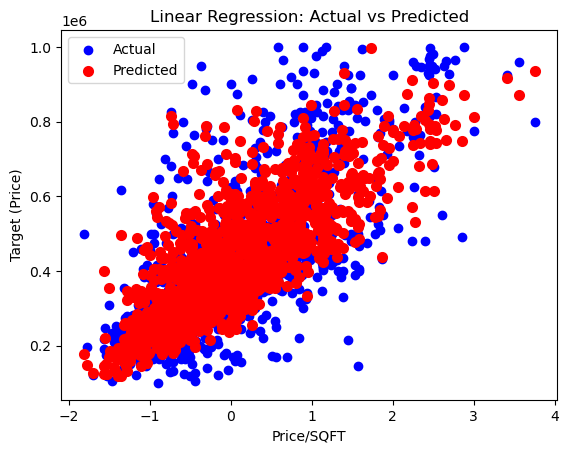

Tuned Hyperparameters :(Best Parameters)  {'fit_intercept': True}
Training R_Squared: -84178.58377870065
Training Metrics:
Testing R_Squared:  -82636.84322303478
MSE:  6828847857.868429
RMSE:  82636.84322303478
MAE:  57458.773975908276
MAPE:  15.111518488495895
Adjusted R2 Score:  0.7798653277137164

Test Metrics:
Testing R_Squared:  -84190.37461865855
MSE:  7088019178.430066
RMSE:  84190.37461865855
MAE:  59811.55744307934
MAPE:  15.92838478629137
Adjusted R2 Score:  0.7665581909978233



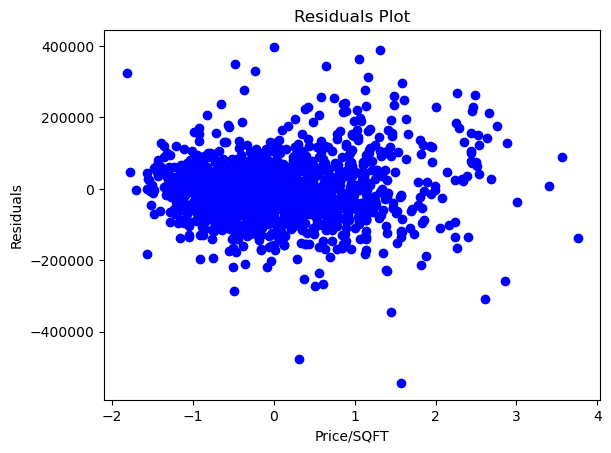

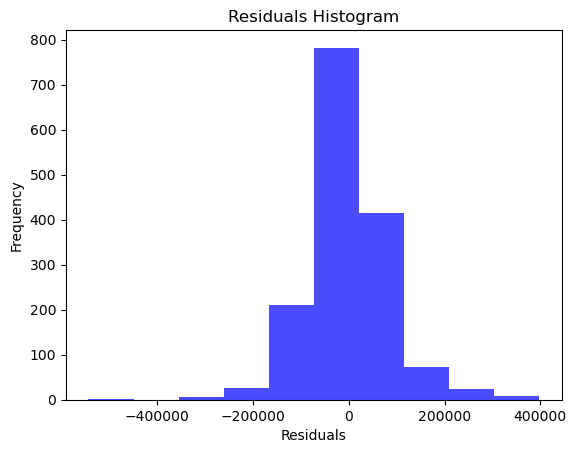

In [165]:
'''
Build, train, test, and validate a LinearRegression() model
'''

MODEL.append('Linear Regression')

# Build, train, and test the model
parameters = {'fit_intercept':[True, False]}
lr = LinearRegression()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
linReg = GridSearchCV(estimator=lr, param_grid=parameters, cv=rkf, scoring='neg_root_mean_squared_error')
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)

# Visualize the results
plt.scatter(X_test.iloc[:,1], y_test, color='blue', label='Actual')
plt.scatter(X_test.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Price/SQFT')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters :(Best Parameters) ",linReg.best_params_)
print("Training R_Squared:",linReg.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(linReg.best_score_)
print('Training Metrics:')

score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, linReg.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, linReg.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, linReg.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, linReg.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
score_lr = r2_score(y_train, linReg.predict(X_train))
n = len(y_train)
k = X_train.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = linReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_test, y_pred)
# print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(X_test.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Price/SQFT')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

del residuals

Test Metrics:
Testing R_Squared:  -0.0
MSE:  7150473240.771202
RMSE:  84560.47091147969
MAE:  58620.31154422195
MAPE:  12.76246775209178
Adjusted R2 Score:  0.7619339717550178



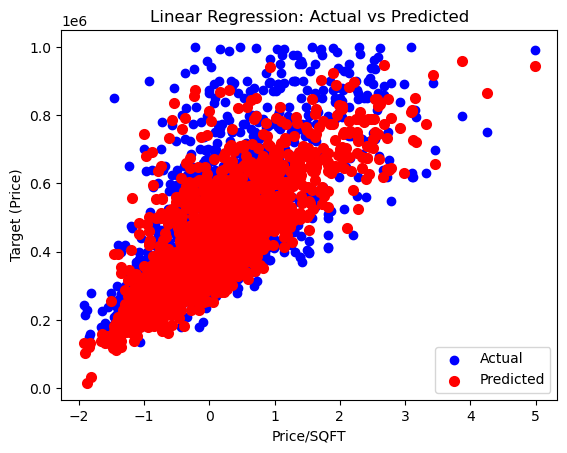

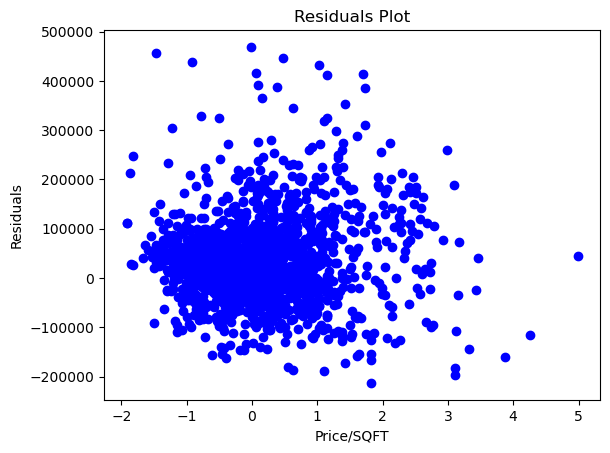

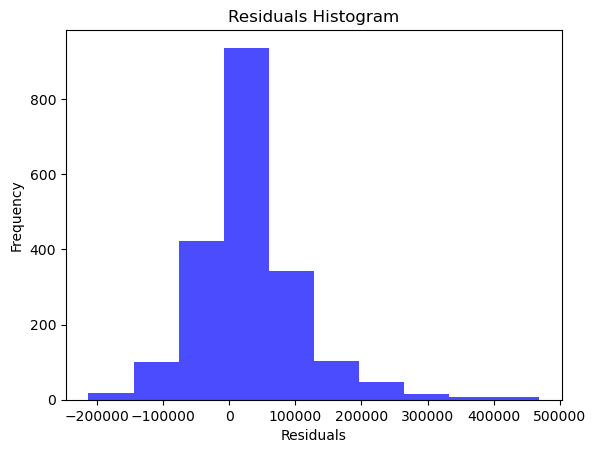

In [166]:
'''
Run LinearRegresion() Model on forSale Data
'''

y_pred = linReg.predict(X_forSale)

print('Test Metrics:')
score_lr = linReg.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_forSale, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_forSale.iloc[0:-1], y_pred[0:-1])
# print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale.iloc[:,1], y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Price/SQFT')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Price/SQFT')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

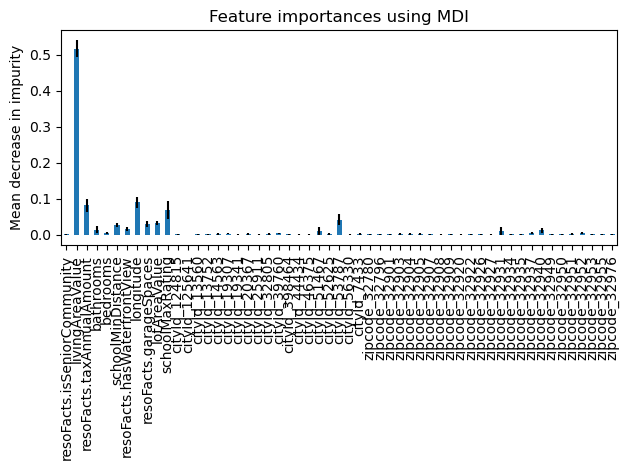

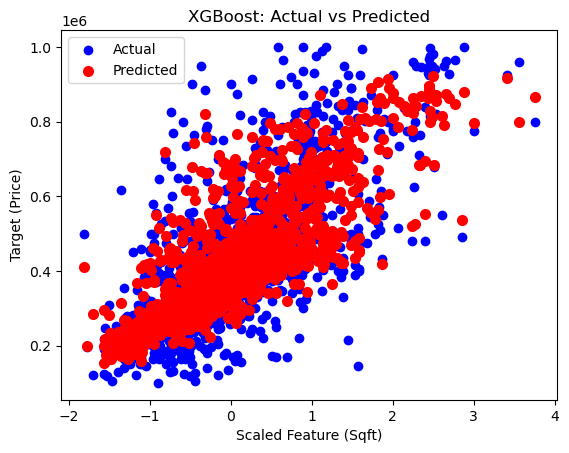

Tuned Hyperparameters: (Best Parameters)  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Estimator:  RandomForestRegressor(max_depth=20, n_estimators=150, random_state=42)
Training R_Squared: -78698.39589601362
Training Metrics:
MSE:  895914152.2847569
RMSE:  29931.825074404616
MAE:  20455.186474605853
MAPE:  5.466272522325079

Test Metrics:
Testing R_Squared:  -84642.17673442162
MSE:  7164298082.3410635
RMSE:  84642.17673442162
MAE:  55811.10239691361
MAPE:  14.990749540552756
MSLE:  0.043135448635257305
Adjusted R2 Score:  0.7640459679254203



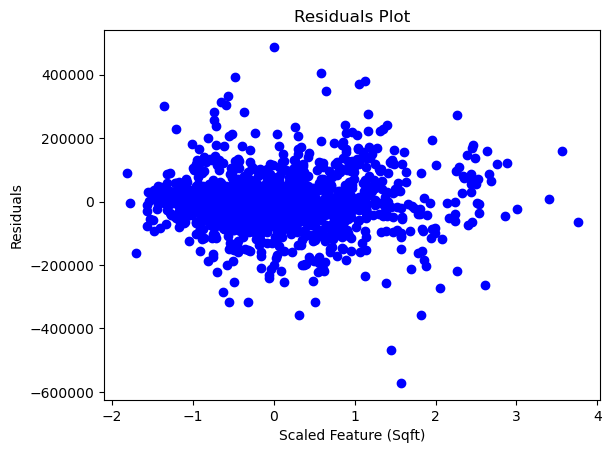

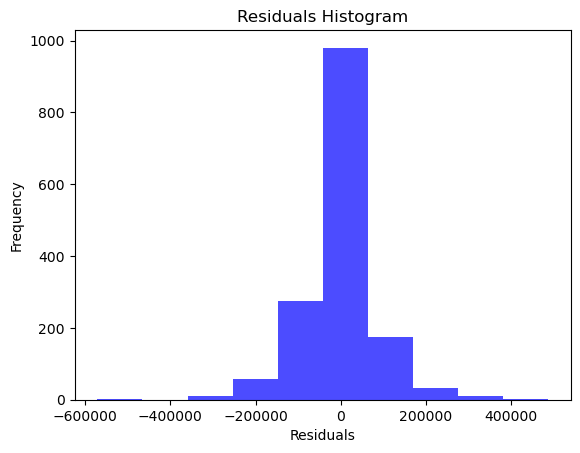

In [167]:
'''
Build, train, test, and validate a RandomForest() model
'''

MODEL.append('Random Forest')

# Build, train, and test the model
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# parameters = {'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [50]}

rf = RandomForestRegressor(random_state=42)
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
randFor = GridSearchCV(estimator=rf, param_grid=parameters, cv=rkf, scoring='neg_root_mean_squared_error', n_jobs=-1)
randFor.fit(X_train, y_train)
best_randFor = randFor.best_estimator_
y_pred = best_randFor.predict(X_test)
y_pred_RF = y_pred.copy()


# Plot feature importance
importances = best_randFor.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_randFor.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_recentlySold.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Visualize the results
plt.scatter(X_test.iloc[:,1], y_test, color='blue', label='Actual')
plt.scatter(X_test.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters: (Best Parameters) ",randFor.best_params_)
print("Best Estimator: ",randFor.best_estimator_)
print("Training R_Squared:",randFor.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(randFor.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, best_randFor.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, best_randFor.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, best_randFor.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, best_xgb_model.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, best_xgb_model.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = randFor.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Test Metrics:
Testing R_Squared:  1.0
MSE:  7944469533.517596
RMSE:  89131.75378908236
MAE:  56915.95061235577
MAPE:  11.880279962872764
Adjusted R2 Score:  0.7354988621489036



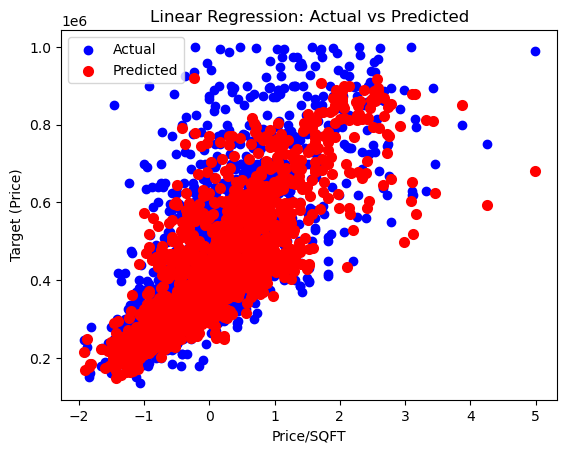

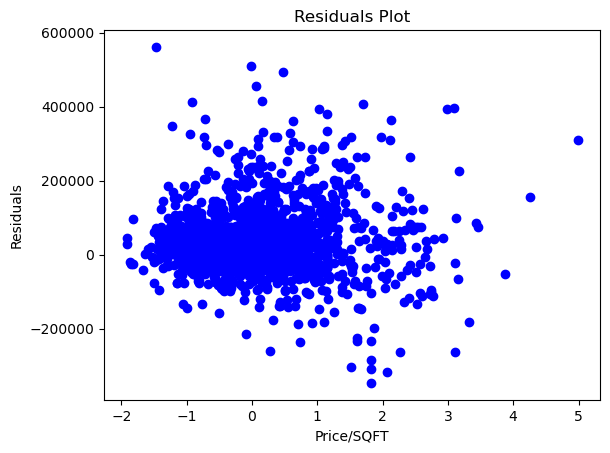

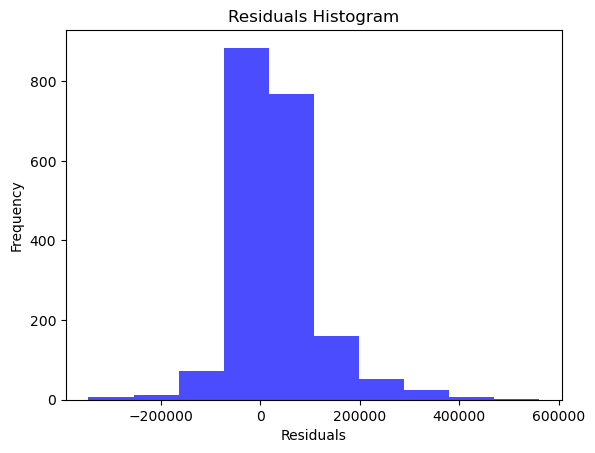

In [168]:
'''
Run RandomForest() Model on forSale Data
'''

y_pred = best_randFor.predict(X_forSale)

print('Test Metrics:')
score_lr = best_randFor.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_forSale, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_forSale.iloc[0:-1], y_pred[0:-1])
# print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale.iloc[:,1], y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Price/SQFT')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Price/SQFT')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

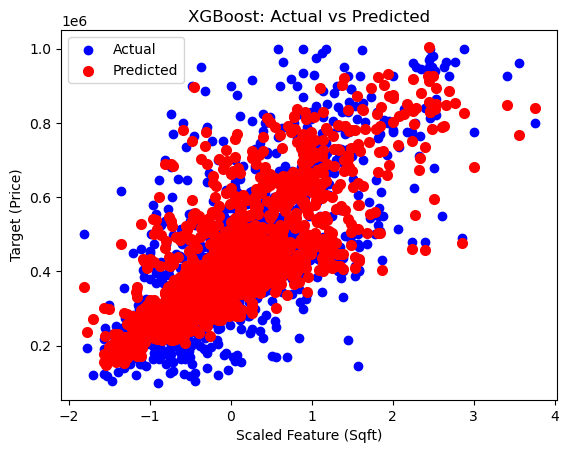

Tuned Hyperparameters: (Best Parameters)  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 150, 'subsample': 1.0}
Best Estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Training R_Squared: -74217.69064159022
Training Metrics:
MSE:  17144

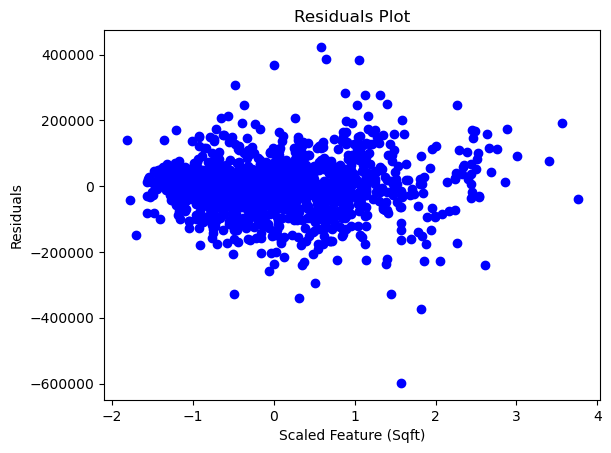

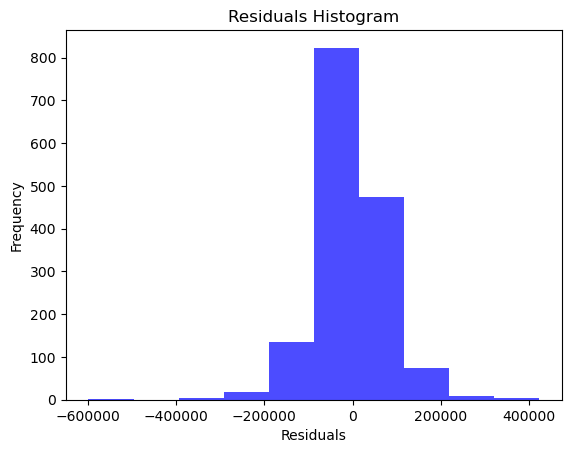

In [169]:
'''
Build, train, test, and validate a XGBoost() model
'''
MODEL.append('XGBoost')

# Build, train, and test the model
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2]
}

# parameters = {
#     'n_estimators': [150],
#     'max_depth': [5],
#     'learning_rate': [0.1],
#     'subsample': [0.8],
#     'colsample_bytree': [1.0],
#     'min_child_weight': [5],
#     'gamma': [0]
# }

# xg = XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)
xg = XGBRegressor(objective='reg:squarederror', random_state=42)
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
boost = GridSearchCV(estimator=xg, param_grid=parameters, cv=rkf, scoring='neg_root_mean_squared_error', n_jobs=-1)
boost.fit(X_train, y_train)

best_xgb_model = boost.best_estimator_

y_pred = best_xgb_model.predict(X_test)

# for i, value in enumerate(y_pred):
#     if value < 0:
#         y_pred[i] = 0

y_pred_XGB = y_pred.copy()

# Visualize the results
plt.scatter(X_test.iloc[:,1], y_test, color='blue', label='Actual')
plt.scatter(X_test.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters: (Best Parameters) ",boost.best_params_)
print("Best Estimator: ",boost.best_estimator_)
print("Training R_Squared:",boost.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(boost.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, best_xgb_model.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_train, best_xgb_model.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, best_xgb_model.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, best_xgb_model.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, best_xgb_model.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = score_lr/np.mean(y_test) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

Test Metrics:
Testing R_Squared:  1.0
MSE:  6615222797.741904
RMSE:  81334.01992857542
Scatter Index:  0.18205457494423982
MAE:  53924.176447979415
MAPE:  11.413958710444074
Adjusted R2 Score:  0.7797544631823249



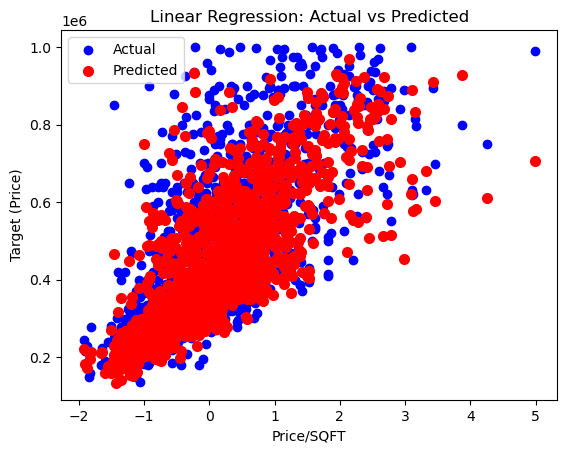

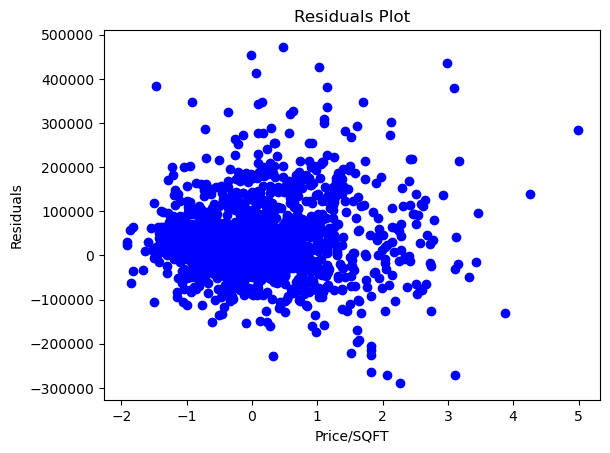

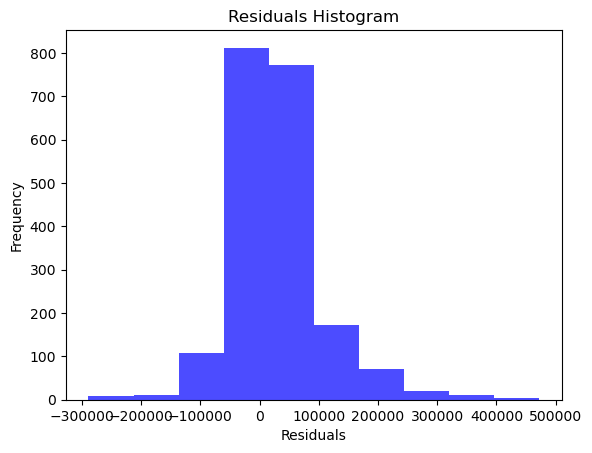

In [170]:
'''
Run XGBoost() Model on forSale Data
'''

y_pred = best_xgb_model.predict(X_forSale)

print('Test Metrics:')
score_lr = best_xgb_model.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_forSale, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = score_lr/np.mean(y_forSale) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_forSale.iloc[0:-1], y_pred[0:-1])
# print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale.iloc[:,1], y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Price/SQFT')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Price/SQFT')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

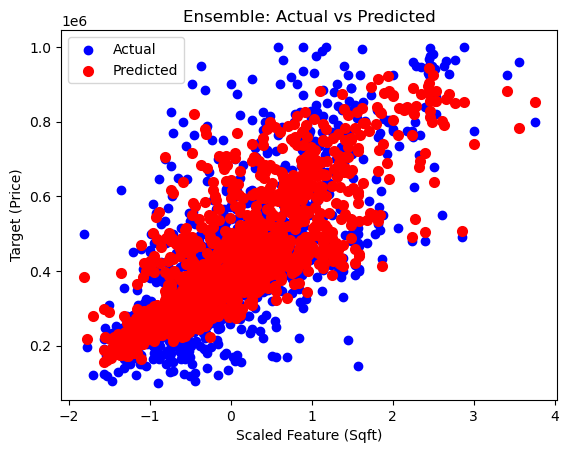

MSE:  6287298445.844118
RMSE:  79292.48669227191
Scatter Index:  0.1872104522823953
MAE:  53012.194137954415
MAPE:  14.313940598335249
MSLE:  0.03863748361797348
Adjusted R2 Score:  0.7929296907941618



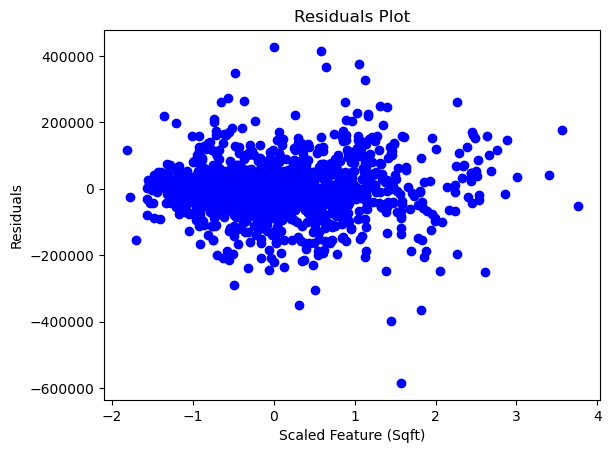

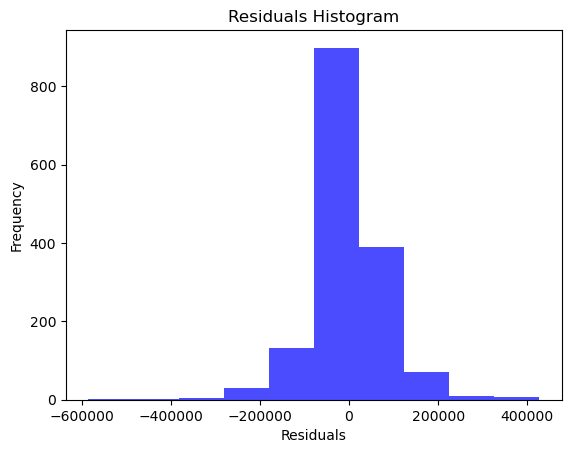

In [171]:
'''
Create Ensemble Model from RandomForest and XGBoost
'''
MODEL.append('Ensemble')

y_pred = (y_pred_RF + y_pred_XGB) / 2

# Visualize the results
plt.scatter(X_test.iloc[:,1], y_test, color='blue', label='Actual')
plt.scatter(X_test.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Ensemble: Actual vs Predicted')
plt.legend()
plt.show()

Training_R2.append(None)
MSE.append(None)
RMSE.append(None)
MAE.append(None)
MAPE.append(None)
MSLE.append(None)


# print('Test Metrics:')
# score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

MSE:  6996154486.022276
RMSE:  83643.01815466893
Scatter Index:  0.1974821059625859
MAE:  54155.659521528694
MAPE:  11.356429934076715
Adjusted R2 Score:  0.7670718209280365



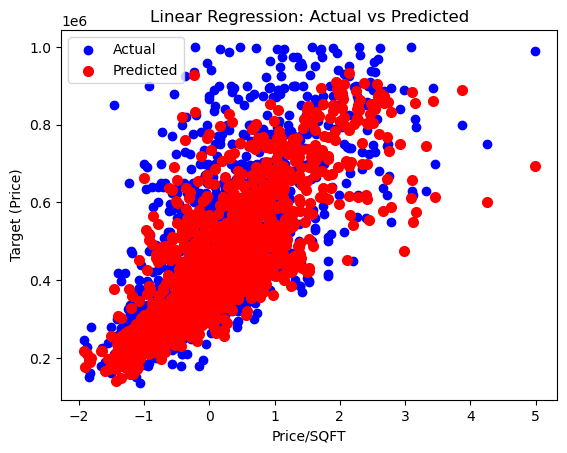

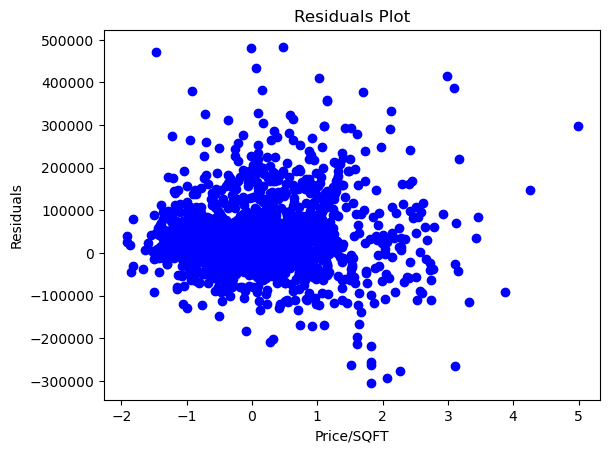

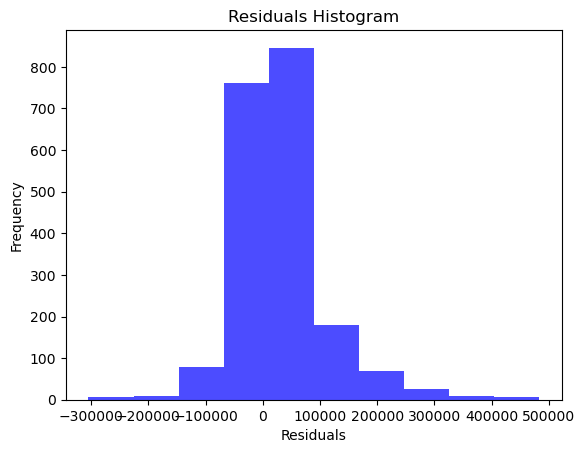

In [172]:
'''
Run Ensemble Model on forSale Data
'''


y_pred = (best_randFor.predict(X_forSale) + best_xgb_model.predict(X_forSale)) / 2
# y_pred = best_xgb_model.predict(X_forSale)

# print('Test Metrics:')
# score_lr = best_xgb_model.score(X_forSale, y_pred) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_forSale, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = score_lr/np.mean(y_train) # <-- Scatter Index. Less than 10% is good. Less than 5% is GREAT. Less than 30% with an adjusted R2 score of > 75% is a win.
print('Scatter Index: ', score_lr)
score_lr = mean_absolute_error(y_forSale, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_forSale, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_forSale.iloc[0:-1], y_pred[0:-1])
# print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_forSale, y_pred)
n = len(y_forSale)
k = X_forSale.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')


# Visualize the results
plt.scatter(X_forSale.iloc[:,1], y_forSale, color='blue', label='Actual')
plt.scatter(X_forSale.iloc[:,1], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Price/SQFT')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Plot errors
residuals = y_forSale - y_pred
# Scatter plot of residuals
plt.scatter(X_forSale.iloc[:,1], residuals, color='blue', marker='o')
plt.xlabel('Price/SQFT')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

---
End of section.
## <pre><-- Previous: EDA                                               Next: Data Visualization --></pre>